In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

In [ ]:
#file = '/Users/gbenz/Downloads/tx10pETCCDI_mon_HadGEM3-GC31-LL_historical_r1i1p1f3_b1981-2010_v20190624_185001-201412_v2-0.nc'

In [1]:
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import numpy as np

from utils.unzip import unzip_etccdi_package
from utils.correct_longitude import transform_longitudinal_values
from utils.give_metadata import give_metadata
from utils.temporal_index import find_etccdi_timeindex, translate_index_to_daterange
from utils.define_request import generate_and_validate_request

# Build API Request -----------------------------------------------------------------

from utils.cds_api_pull import pull_from_cds_api


# Methods ---------------------------------------------------------------------------
from utils.etccdi_to_pg__pointquery import generate_etccdi_temporal_tables__centroid
from utils.etccdi_to_pg import generate_etccdi_temporal_tables

# Validation ------------------------------------------------------------------------
from utils.give_reference_frame import provide_reference_frame
from utils.id_null_values import report_null_etccdi_values


## Access with Copernicus Data Store API:

### Link for instructions on how to set up the API 

#### This is a necessary precondition to run the toolbox built here

The final objective is to construct a main.py function that accepts the parameters below and automatically computes the process!

## Insert Parameters:


#### Parameters informing the API request:
- variable 
- product_type
- experiment
- temporal_aggregation

#### Parameters informing processing:
- start_year = '1995'
- start_month = '01'
- end_year = '2000'
- end_month = '12'

#### Select a `Method`:
- Bilinear sampling
- Point neighbor

dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["maximum_value_of_daily_minimum_temperature"],
    "product_type": ["base_independent"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["monthly"],
    "period": ["201501_210012"],
    "version": ["2_0"]
}

In [2]:
p_variable="maximum_value_of_daily_minimum_temperature"
p_product_type="base_independent"
p_experiment="ssp1_2_6"
p_temporal_aggregation="monthly"

#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '2015'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '2015'
end_month = '04'
#-----------------------------------------------------------
method = 'resample'


In [3]:
# Now, calling the function will generate and validate the request
request = generate_and_validate_request(
    variable=p_variable,
    product_type=p_product_type,
    experiment=p_experiment,
    temporal_aggregation=p_temporal_aggregation
)

display(request)

#-------------------------------------------------------------------
# Load a clean PG dataframe at a consistent temporal resolution
# to the request built
#-------------------------------------------------------------------

reference_df = provide_reference_frame(request)

Request is valid.


{'variable': ['maximum_value_of_daily_minimum_temperature'],
 'product_type': ['base_independent'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['ssp1_2_6'],
 'temporal_aggregation': ['monthly'],
 'period': ['201501_210012'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

month_id         int64
priogrid_gid     int64
year            object
month           object
dtype: object


In [4]:
zip_file_name = pull_from_cds_api(request)

2024-11-14 11:55:38,851 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-14 11:55:38,851 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-14 11:55:38,852 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-14 11:55:38,852 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

2551a872c032655ebcce86a6bd26b97c.zip:   0%|          | 0.00/109M [00:00<?, ?B/s]

In [5]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

tnxETCCDI
Extracted file names: tnxETCCDI_mon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_no-base_v20200114_201501-210012_v2-0.nc


### Report Metadata from the selected ETTCDI netCDF file:

Move the pg shapefile to the github repo so this can be accessed without references to local paths

Accomplishes:
- checks to ensure the correct netcdf file is being processed
- provides spatial and temporal metadata

From preprocessing, we know that the ETCCDI climate data is not packaged in a desirable format, that is, the original longitudinal range is: 0.9375 to 359.0625
- Adjust the Longitude range 
- save an 'adjusted netcdf' file.


28-10 -- What would perhaps be most desirable is to first transform, then, report metadata with two seperate functions.

In [6]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'tnxETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Adjusted dataset saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/netcdf/adjusted_tnxETCCDI_mon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_no-base_v20200114_201501-210012_v2-0.nc.nc


In [7]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 09:31:53 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-20491230.nc tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20500101-21001230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-21001230.nc
2020-01-13T09:55:40Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2020-01-13T09:53:59Z MIP Convert v1.2.3, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 degree in the 

In [8]:
index_list, reference_filtered_time = translate_index_to_daterange(etccdi, reference_df, start_year, start_month, end_year, end_month)

Index of 01 data for year 2015: 0
Validation: Found data for Year: 2015, Month: 01 at index 0.

Index of 04 data for year 2015: 3
Validation: Found data for Year: 2015, Month: 04 at index 3.

The start index is: 0, referencing Month: 01 and Year: 2015

The end index is: 3, referencing Month: 04 and Year: 2015

         month_id  priogrid_gid  year month
5506200       421         62356  2015     1
5506201       421         79599  2015     1
5506202       421         79600  2015     1
5506203       421         79601  2015     1
5506204       421         80317  2015     1
...           ...           ...   ...   ...
5663515       432        190496  2015    12
5663516       432        190507  2015    12
5663517       432        190508  2015    12
5663518       432        190510  2015    12
5663519       432        190511  2015    12

[157320 rows x 4 columns]


### Puts it all together

Parameters:
1. references the sub_index which supplies the list (or sublist) of indexes to iterate over. Index specifically references time. This can be confusing because the ETCCDI variables are themselves climate indices.
2. Creates a single geotiff from the current time selection. We do this because the NetCDF itself is not a format that can be incorporated into rigorous analysis so as we iterate through the time series we convert the working item to a geotiff which is a format that can be operated on.


#### Parameters:

1. NetCDF file
2. (TEMPORAL) sub_index or full index (specify index to loop over)
3. etccdi index ex(tx10pETCCDI)


ADF -- Decision to just save to ONE WORKING raster that will continously be rewritten 
rationale: The purpose of having unique tifs is to visualize holes in the data. However, this is not worth the space. If holes appear in the tabular dataset, a new geotiff corresponding to that month / year can quickly be produced!

ADF -- Rationalize why this is best:
    # Resample the raster data to the new resolution
    resampled_raster = raster_data.rio.reproject(
        raster_data.rio.crs,
        shape=(
            int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
            int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
        ),
        resampling=Resampling.bilinear  # Use the correct resampling method
    )


### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path


## Summarize Option 1:

This code generates temporal statistics for a specified climate index by iterating over selected time indices in a NetCDF file. For each time index, it reads climate data, handles data types, renames spatial dimensions, and ensures the correct CRS is set. The data is saved as both an original raster and a modified version with null values set to -9999. Using bilinear interpolation, the code then upscales the raster data by a specified factor and saves this upsampled raster. The upsampled raster is used to compute zonal statistics over regions defined in a shapefile, and these statistics are stored in a GeoDataFrame. Each resulting GeoDataFrame, containing the mean climate index values per region, is appended to a list. After processing all time indices, the code concatenates the list into a final DataFrame, which is saved as a CSV file in the specified output folder. Optional plots display the data at each step.

# Summarize Option 2:

This code processes climate index data from a NetCDF file and extracts raster values for specific geographic regions over multiple time indices. It starts by loading a shapefile of geographic zones and calculates centroids for each polygonal region. For each time index, it reads climate data corresponding to a specific parameter, converting it to days if necessary, and setting spatial dimensions and CRS if undefined. The raster data is temporarily saved as a GeoTIFF file, and the point_query function is used to sample raster values at the centroids of each zone. These sampled values are added to the shapefile's GeoDataFrame and stored in a list for each time index. After the loop, all GeoDataFrames are concatenated into a single DataFrame (final_gdf), which is saved as a CSV file. The script also includes optional plotting of each time slice and closes the NetCDF file when finished.

## Expanding on an recurring issue:

Resampling and Masking
When you resample a raster, you're creating a new grid with finer or coarser resolution based on the original raster. The new grid’s cells are re-sized compared to the original cells. For example, if you resample a raster by a factor of 3, the original cells are subdivided into 9 smaller cells (in a 3x3 grid).

A mask is a boolean grid (same resolution as the raster) used to filter out or mark specific areas of interest. This mask typically identifies areas of the raster with valid data (True) or invalid data (False, or NaN, in case of missing data). When resampling, the mask should align with the resampled raster so that only valid cells are used for resampling operations, and invalid cells remain excluded.

However, issues arise if the mask is derived from the original grid, and you resample that original grid. Here's why:

The Root Cause of Misalignment
Misalignment of Grids:
After resampling, the new raster's resolution is finer, which means you now have smaller cells within the same bounding box. But since you're using the original raster's mask (which was designed for the coarser grid), this mask will no longer fit exactly with the new raster. The finer resolution raster has different boundaries, so the mask may not align correctly to the finer grid cells.
In other words:

The original mask may cover a large region (since it was based on the coarser grid cells).
The new resampled raster will now have many more cells that represent the same area, but the mask won't scale automatically to match the new resolution.
Valid Mask Misalignment: The original raster's valid mask might indicate areas of valid data and invalid data at a coarse resolution, but once you resample, the mask needs to be resampled in the same way as the data. This allows the valid/invalid distinction to remain accurate for each finer cell.
However, if you don't reapply the valid mask to the resampled raster, or if the resampling of the mask is not done properly, you'll end up with an incorrect alignment between the valid and invalid areas. This can result in several issues:

The resampling process might use invalid data (or leave gaps in data) in areas where the mask says the data should be valid.
The finer grid might end up with spatial misalignment where valid areas on the original grid are incorrectly marked as invalid (or vice versa) on the finer grid.
More Specifically:
Resampling Method and Masking: When you perform resampling, the method you choose (e.g., bilinear, cubic) may try to interpolate the values of neighboring cells. If the original cells have null values or missing data, the resampling method may propagate these null values into the newly resampled cells, unless you specifically exclude them from the interpolation process. This could lead to introducing new null areas in the resampled raster.
For example, if you have a coarser raster with some missing data, and you choose bilinear interpolation for resampling, the new finer cells may get assigned interpolated values from neighboring cells that had data. But if those neighboring cells also have missing data, this could result in interpolated null values, leading to a larger area of missing data than you originally had.
When the Mask Doesn't Align: Consider this scenario:
The original raster has cells with valid data, but those valid cells may not exactly match the boundaries of the finer resampled raster.
If you simply apply the original valid mask (from the coarser raster) to the finer resampled raster without rescaling or adjusting the mask, you could misalign areas of valid data and invalid data.
In practice:

If the original mask had valid data in one coarse cell, after resampling, that coarse cell becomes nine smaller cells. Some of those smaller cells might fall into areas where the mask from the coarser raster still marks them as invalid (because the original mask was larger and not rescaled).
The new cells in the resampled raster should be individually checked for validity. A resampled mask ensures that only the valid data is used for interpolation and no new invalid data is introduced.
A Visual Example: Let's say your original raster has a grid with one valid cell, and the surrounding cells are null (missing). After resampling:
Without a rescaled mask, some of the new finer grid cells could be treated as valid, even though the original data was null.
With the correct rescaled mask, the valid area is preserved in the resampled grid, and only valid data is used to fill the finer cells.
Conclusion:
The problem occurs because you need to resample both the data and the mask at the same time. If the mask isn't rescaled to match the new finer grid, areas that should be marked as invalid might get wrongly marked as valid, leading to interpolation errors. These errors may introduce new null values where they didn’t exist in the original raster, because the resampling method tries to fill in gaps based on a misaligned mask.
To avoid this:

Ensure that both the data and the mask are resampled with the same grid size.
Resample the mask correctly to the finer resolution, maintaining the valid and invalid regions, so that the resampling of the data follows the mask boundaries exactly.
If interpolation is involved, make sure to avoid interpolating over null values to prevent the introduction of invalid data.
In Summary:
Misalignment occurs when the resampling process changes the raster's resolution but fails to correctly adjust the associated valid mask. When the mask isn't resampled, you risk introducing new null areas or misclassifying valid/invalid cells. This can create errors in downstream processes, such as zonal statistics or further analysis, where invalid data is improperly considered valid or vice versa.

### Changes to make:

for the shapefile (extent) --- the parameter here is LOOKING for a shapefile in a specific folder. Specifically in the data/processed folder. It will automatically look for whatever the PRIOGRID.shp file is. However, if the PSI team or some other research endeavor has their own fishnet to apply, that shapefile should also be located in the folder. Therefore, the input here DOES NOT need to be filled if it is anything OTHER THAN the standard PG extent. if it is, the parameter should simply be set as the name + extension (example: pgm_viewser_extent.shp)

- set the folder parameter as a standard (so that it does not need to be typed in!)

Processing time index: 0
Year: 2015 Month: 01
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


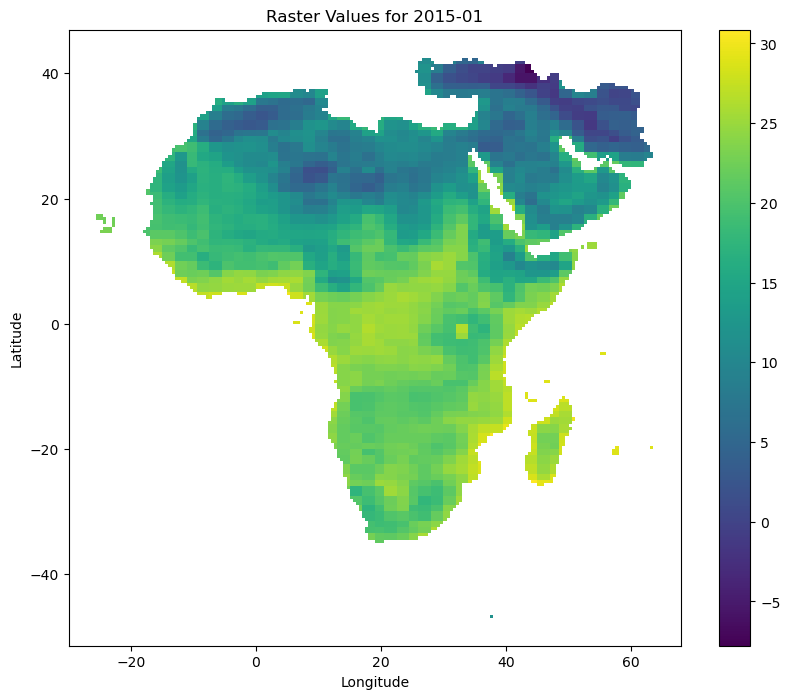

Processing time index: 1
Year: 2015 Month: 02
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


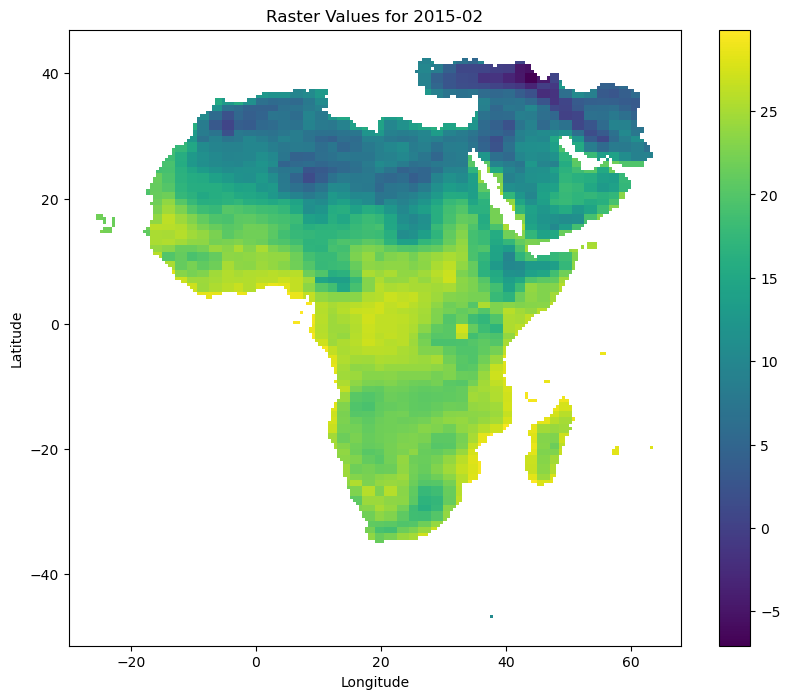

Processing time index: 2
Year: 2015 Month: 03
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


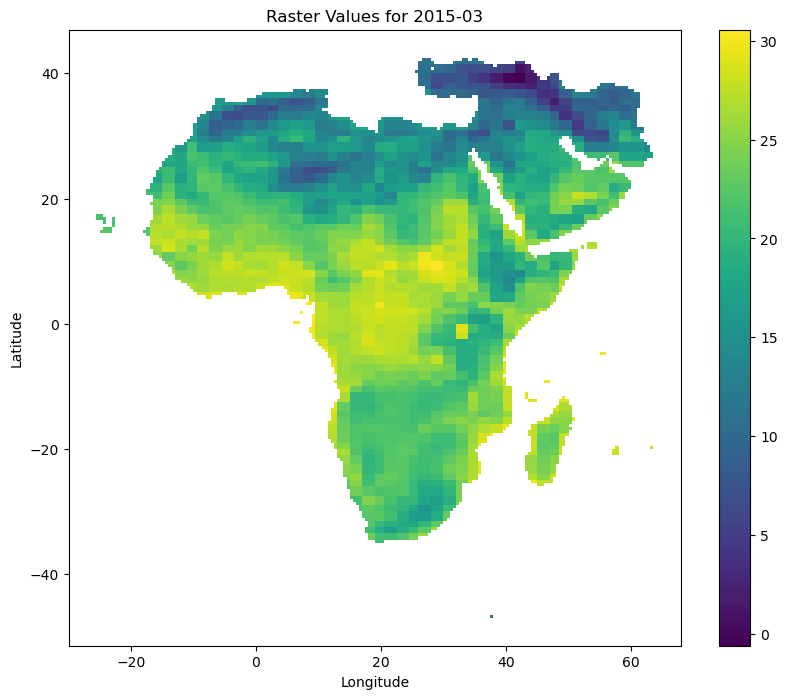

Processing time index: 3
Year: 2015 Month: 04
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:99: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


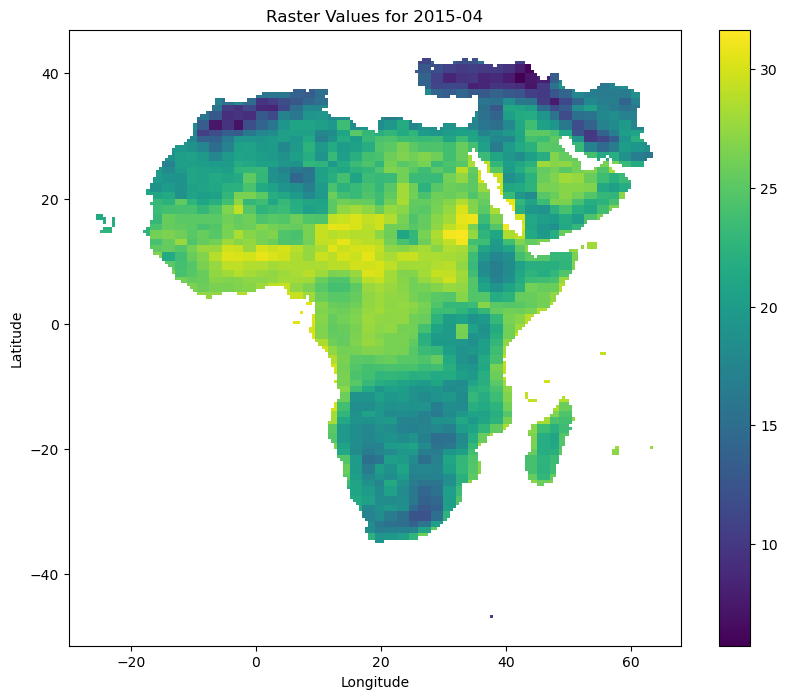

Final DataFrame saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_table_output/tnxETCCDI_0_3__centroid_process.csv
tnxETCCDI_0_3__centroid_process.csv
All graphics saved to /Users/gbenz/Documents/Climate Data/climate_extremes/docs/Graphics/Standard_review/tnxETCCDI_layout.pdf


In [9]:
translated_filename = generate_etccdi_temporal_tables__centroid(index_list, etccdi, etccdi_index)

In [ ]:
generate_etccdi_temporal_tables(index_list, etccdi, etccdi_index, '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp', '/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/')

In [ ]:
validate_etccdi = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/cddETCCDI_140_143__centroid_process.csv')
print(validate_etccdi)

### Review:

#### Validate completeness of the output index at PG resolution:

Temporally: check that all total number of time periods match
- Spatially: Full extent of PG (for each temporal unit!)

How to do this:

1. Load the 'compiled' etccdi index .csv
2. check for null values

Total length should be: X

check length of temporal units should be: X (dependent on input parameters)
check length of spatial units should be: X

3. Plot the data

### What we need:

A complete 'clean' dataframe to reference from VIEWSER! 11.11


In [10]:
report_null_etccdi_values(translated_filename, reference_filtered_time)

Total number of null values in 'validate_etccdi' DataFrame: 0
Total number of null values in 'validate_etccdi' DataFrame: 0
therefore, there is no null summary dataframe to report here!
